In [1]:
import os
from fnmatch import fnmatch
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split,KFold
from sklearn import preprocessing
import seaborn as sns
from sklearn.metrics import confusion_matrix,classification_report
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

### Reading the energy.csv Dataset

In [2]:
df_Energy=pd.read_csv('energydata_complete.csv')
df_Energy.head(3)

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,...,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433
1,2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,...,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195
2,2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,...,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668


### Data Preparation

In [3]:
#Check for Missing Value

df_Energy.isnull().sum()

date           0
Appliances     0
lights         0
T1             0
RH_1           0
T2             0
RH_2           0
T3             0
RH_3           0
T4             0
RH_4           0
T5             0
RH_5           0
T6             0
RH_6           0
T7             0
RH_7           0
T8             0
RH_8           0
T9             0
RH_9           0
T_out          0
Press_mm_hg    0
RH_out         0
Windspeed      0
Visibility     0
Tdewpoint      0
rv1            0
rv2            0
dtype: int64

In [4]:
df_Energy.describe()

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
count,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,...,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000
mean,97.694958,3.801875,21.686571,40.259739,20.341219,40.420420,22.267611,39.242500,20.855335,39.026904,...,19.485828,41.552401,7.411665,755.522602,79.750418,4.039752,38.330834,3.760707,24.988033,24.988033
std,102.524891,7.935988,1.606066,3.979299,2.192974,4.069813,2.006111,3.254576,2.042884,4.341321,...,2.014712,4.151497,5.317409,7.399441,14.901088,2.451221,11.794719,4.194648,14.496634,14.496634
min,10.000000,0.000000,16.790000,27.023333,16.100000,20.463333,17.200000,28.766667,15.100000,27.660000,...,14.890000,29.166667,-5.000000,729.300000,24.000000,0.000000,1.000000,-6.600000,0.005322,0.005322
25%,50.000000,0.000000,20.760000,37.333333,18.790000,37.900000,20.790000,36.900000,19.530000,35.530000,...,18.000000,38.500000,3.666667,750.933333,70.333333,2.000000,29.000000,0.900000,12.497889,12.497889
50%,60.000000,0.000000,21.600000,39.656667,20.000000,40.500000,22.100000,38.530000,20.666667,38.400000,...,19.390000,40.900000,6.916667,756.100000,83.666667,3.666667,40.000000,3.433333,24.897653,24.897653
75%,100.000000,0.000000,22.600000,43.066667,21.500000,43.260000,23.290000,41.760000,22.100000,42.156667,...,20.600000,44.338095,10.408333,760.933333,91.666667,5.500000,40.000000,6.566667,37.583769,37.583769
max,1080.000000,70.000000,26.260000,63.360000,29.856667,56.026667,29.236000,50.163333,26.200000,51.090000,...,24.500000,53.326667,26.100000,772.300000,100.000000,14.000000,66.000000,15.500000,49.996530,49.996530


### Correlation plot to pick out the best features for the model

Text(0.5,1,'Heatmap of Variables')

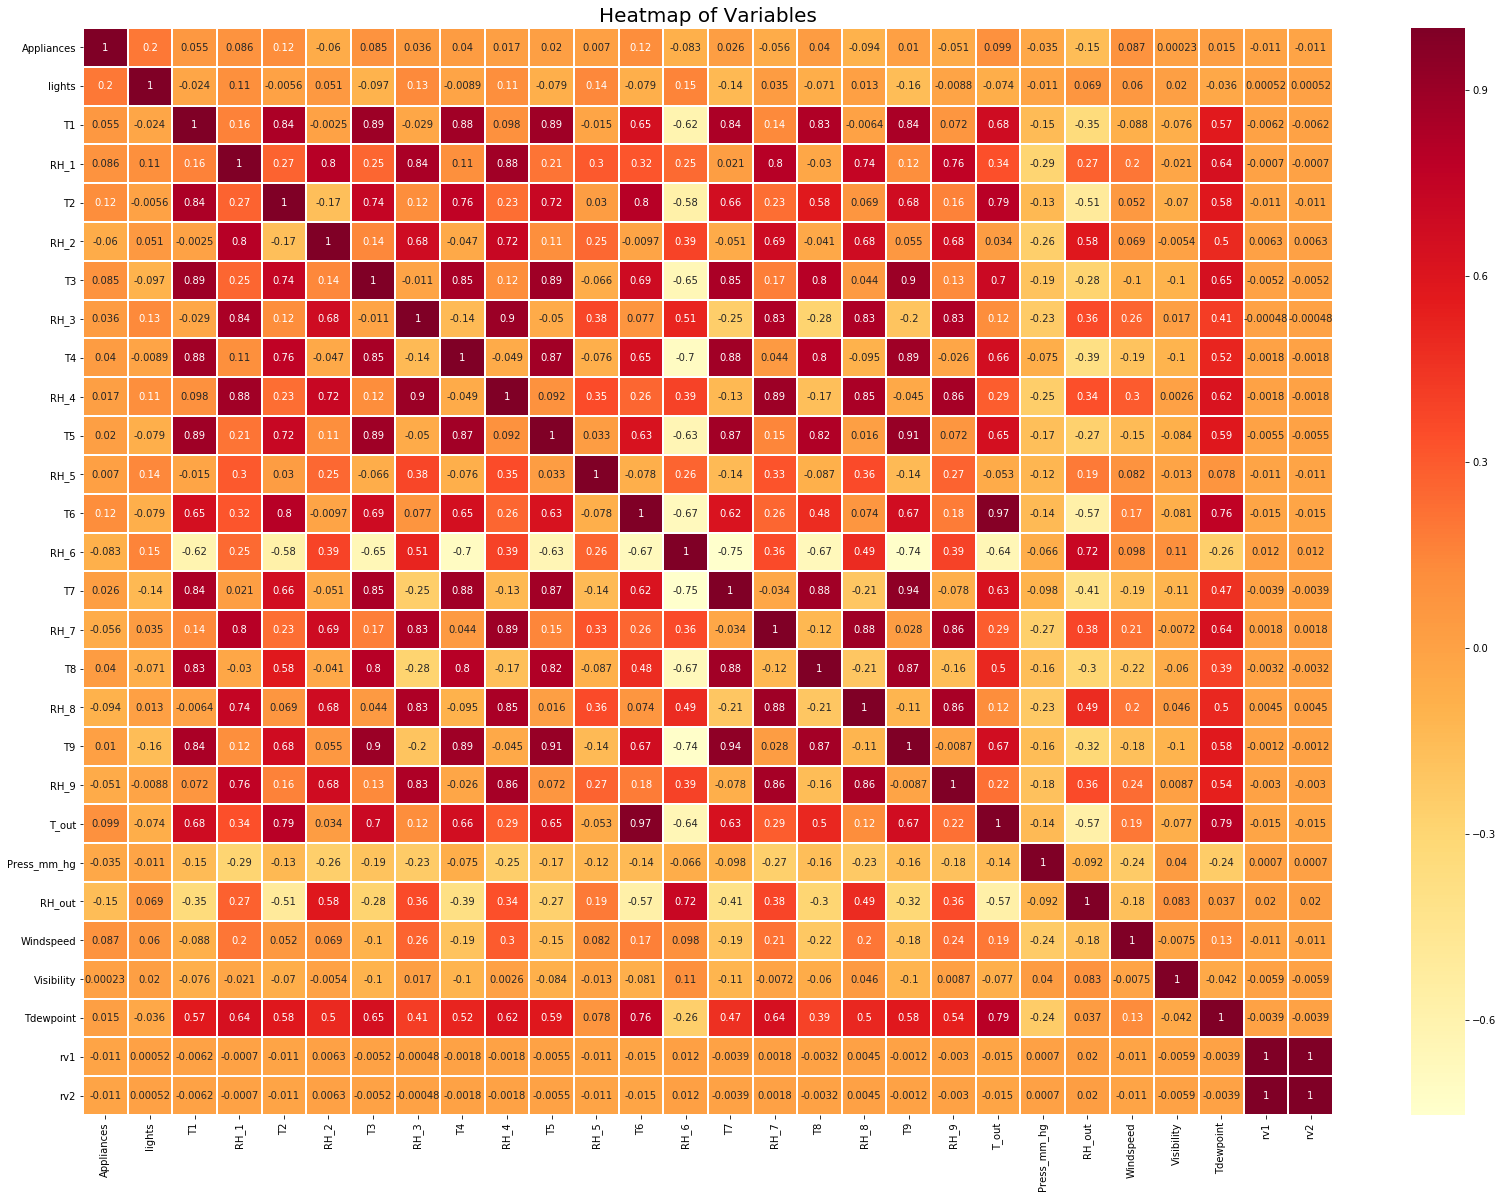

In [5]:
#Correlation:

fig = plt.figure(figsize=(28,20))

axis = sns.heatmap(df_Energy.corr(), cmap= 'YlOrRd', linewidth=1, linecolor='white', annot=True)
axis.set_title('Heatmap of Variables', fontsize=20)

### For the feature selection we are implementing the elimination using correlation backed up by the business intuition-

In [6]:
corr_matrix = df_Energy.corr().abs()

#the matrix is symmetric so we need to extract upper triangle matrix without diagonal (k = 1)

sol = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
                 .stack()
                 .sort_values(ascending=False))
sol = sol.to_frame()
sol.columns=['corr']
sol[sol['corr'] >  0.88]

,,corr
rv1,rv2,1.000000
T6,T_out,0.974787
T7,T9,0.944776
T5,T9,0.911055
T3,T9,0.901324
RH_3,RH_4,0.898978
RH_4,RH_7,0.894301
T1,T3,0.892402
T4,T9,0.889439
T3,T5,0.888169


In [7]:
df_Energy.columns

Index(['date', 'Appliances', 'lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3',
       'RH_3', 'T4', 'RH_4', 'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8',
       'RH_8', 'T9', 'RH_9', 'T_out', 'Press_mm_hg', 'RH_out', 'Windspeed',
       'Visibility', 'Tdewpoint', 'rv1', 'rv2'],
      dtype='object')

### Below are the final 10 Features along with target variable 'Appliances' that we selected for the further Analysis

In [8]:
df_final = df_Energy[['T1', 
                     'T2', 
                     'RH_1', 
                     'RH_2',
                     'RH_6', 
                     'T_out',
                     'lights',
                     'Windspeed',
                     'RH_out', 
                     'Appliances',
                     'Press_mm_hg',
                     'rv1',
                     'Tdewpoint']]

df_final['Appliances_Energy'] = np.where(df_final['Appliances']>= 60, 1, 0)
df_final.drop(columns=['Appliances'],axis=1,inplace=True)

In [9]:
df_final.head()

,T1,T2,RH_1,RH_2,RH_6,T_out,lights,Windspeed,RH_out,Press_mm_hg,rv1,Tdewpoint,Appliances_Energy
0,19.89,19.2,47.596667,44.790000,84.256667,6.600000,30,7.000000,92.0,733.5,13.275433,5.3,1
1,19.89,19.2,46.693333,44.722500,84.063333,6.483333,30,6.666667,92.0,733.6,18.606195,5.2,1
2,19.89,19.2,46.300000,44.626667,83.156667,6.366667,30,6.333333,92.0,733.7,28.642668,5.1,0
3,19.89,19.2,46.066667,44.590000,83.423333,6.250000,40,6.000000,92.0,733.8,45.410389,5.0,0
4,19.89,19.2,46.333333,44.530000,84.893333,6.133333,40,5.666667,92.0,733.9,10.084097,4.9,1


### Final heatmap of the variables that we are going to use with [[SVM, Decision Tress and Boosting] model-

Text(0.5,1,'Heatmap of Variables')

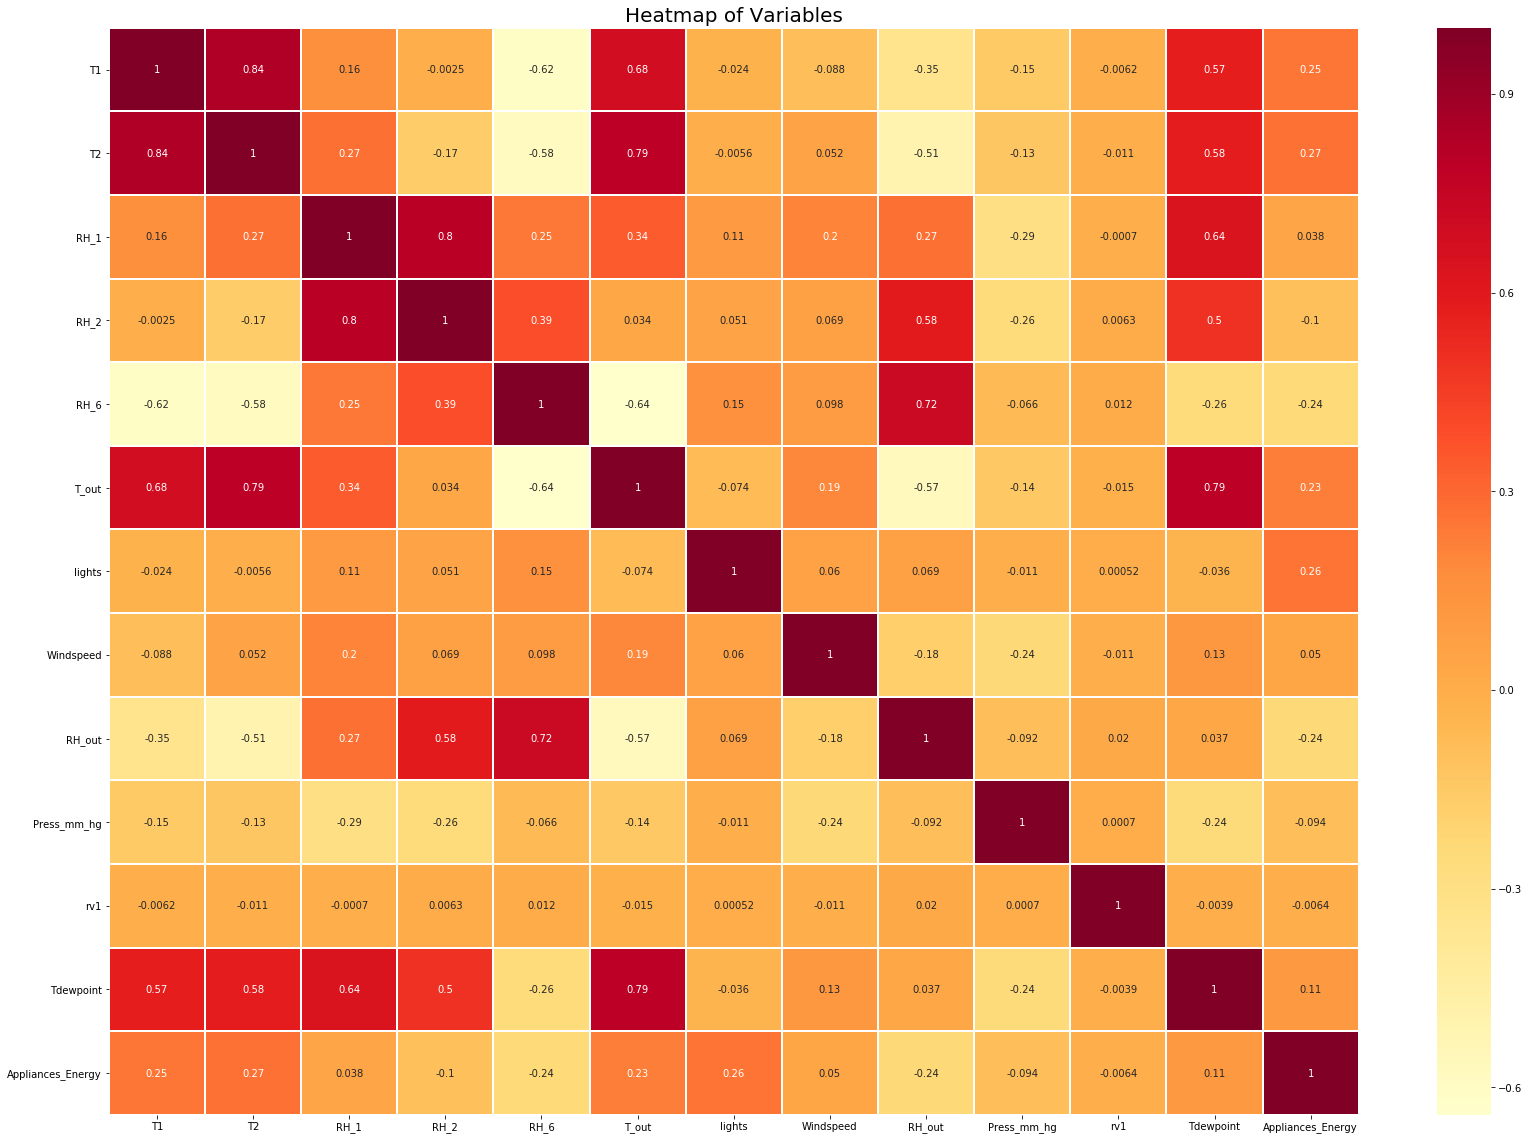

In [10]:
fig = plt.figure(figsize=(28,20))

axis = sns.heatmap(df_final.corr(), cmap= 'YlOrRd', linewidth=1, linecolor='white', annot=True)
axis.set_title('Heatmap of Variables', fontsize=20)

### Train Test Split-

In [11]:
x = df_final.drop(columns=['Appliances_Energy'],axis=1)

y = df_final[['Appliances_Energy']]

xTrain, xTest, yTrain, yTest = train_test_split(x,y, test_size = 0.3, random_state = 0)

In [12]:
print('Shape of xTrain Set', xTrain.shape)
print('Shape of yTrain Set', yTrain.shape)

print('')

print('Shape of xTest Set', xTest.shape)
print('Shape of yTest Set', yTest.shape)

Shape of xTrain Set (13814, 12)
Shape of yTrain Set (13814, 1)

Shape of xTest Set (5921, 12)
Shape of yTest Set (5921, 1)


### Cross-Validation Split-

In [13]:
cv=KFold(n_splits=10)

for train_index, test_index in cv.split(x):
    xTrain_cv,xTest_cv=x.iloc[train_index],x.iloc[test_index]
    yTrain_cv,yTest_cv=y.iloc[train_index],y.iloc[test_index]
    
print('Shape of xTrain Set', xTrain_cv.shape)
print('Shape of yTrain Set', yTrain_cv.shape)

print('')

print('Shape of xTest Set', xTest_cv.shape)
print('Shape of yTest Set', yTest_cv.shape)

Shape of xTrain Set (17762, 12)
Shape of yTrain Set (17762, 1)

Shape of xTest Set (1973, 12)
Shape of yTest Set (1973, 1)


#### Lets have a overlook at the count of classes to check the balance: 

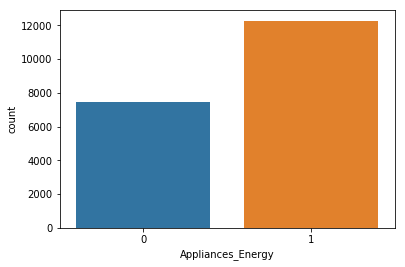

In [14]:
sns.countplot(df_final['Appliances_Energy'])

## [1] SVM:

### Creating function to take kernel as input and run model and provide metrics for any type of SVM

In [31]:
def runModelSVM(k,xTrain,yTrain,xTest,yTest):
    from sklearn.svm import SVC
    
    svc_clf = SVC(kernel=k)
    svc_clf.fit(xTrain,yTrain)
    y_pred=svc_clf.predict(xTest)

    print(' Kernel: ',k)
    print('Train score: {:.4f} %'.format(svc_clf.score(xTrain, yTrain)*100))
    print('Test score: {:.4f} %'.format(svc_clf.score(xTest, yTest)*100))
    print('')
    print('Classification Report:')
    print(classification_report(yTest,y_pred))
    print('Confusion Matrix:')
    print(confusion_matrix(yTest,y_pred))

### Linear Kernel-

In [32]:
print('********************** Result for Train-Test Split **********************\n')
runModelSVM('linear',xTrain,yTrain,xTest,yTest)
print('********************** Result for Cross-Validation **********************\n')
runModelSVM('linear',xTrain_cv,yTrain_cv,xTest_cv,yTest_cv)

********************** Result for Train-Test Split **********************

 Kernel:  linear
Train score: 70.7036 %
Test score: 69.9544 %

Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.56      0.58      2192
           1       0.75      0.78      0.77      3729

   micro avg       0.70      0.70      0.70      5921
   macro avg       0.68      0.67      0.67      5921
weighted avg       0.70      0.70      0.70      5921

Confusion Matrix:
[[1222  970]
 [ 809 2920]]
********************** Result for Cross-Validation **********************

 Kernel:  linear
Train score: 70.1723 %
Test score: 73.3908 %

Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.02      0.04       527
           1       0.74      0.99      0.85      1446

   micro avg       0.73      0.73      0.73      1973
   macro avg       0.65      0.51      0.44      1973
weighted avg       0.69      0.73 

### rbf Kernel-

In [33]:
print('********************** Result for Train-Test Split **********************\n')
runModelSVM('rbf',xTrain,yTrain,xTest,yTest)
print('********************** Result for Cross-Validation **********************\n')
runModelSVM('rbf',xTrain_cv,yTrain_cv,xTest_cv,yTest_cv)

********************** Result for Train-Test Split **********************

 Kernel:  rbf
Train score: 96.5759 %
Test score: 73.8895 %

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.45      0.56      2192
           1       0.74      0.91      0.81      3729

   micro avg       0.74      0.74      0.74      5921
   macro avg       0.74      0.68      0.69      5921
weighted avg       0.74      0.74      0.72      5921

Confusion Matrix:
[[ 976 1216]
 [ 330 3399]]
********************** Result for Cross-Validation **********************

 Kernel:  rbf
Train score: 95.4960 %
Test score: 73.0360 %

Classification Report:
              precision    recall  f1-score   support

           0       0.14      0.00      0.00       527
           1       0.73      1.00      0.84      1446

   micro avg       0.73      0.73      0.73      1973
   macro avg       0.44      0.50      0.42      1973
weighted avg       0.57      0.73      0

### Sigmoid Kernel-

In [34]:
print('********************** Result for Train-Test Split **********************\n')
runModelSVM('sigmoid',xTrain,yTrain,xTest,yTest)
print('********************** Result for Cross-Validation **********************\n')
runModelSVM('sigmoid',xTrain_cv,yTrain_cv,xTest_cv,yTest_cv)

********************** Result for Train-Test Split **********************

 Kernel:  sigmoid
Train score: 61.8503 %
Test score: 62.9792 %

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2192
           1       0.63      1.00      0.77      3729

   micro avg       0.63      0.63      0.63      5921
   macro avg       0.31      0.50      0.39      5921
weighted avg       0.40      0.63      0.49      5921

Confusion Matrix:
[[   0 2192]
 [   0 3729]]
********************** Result for Cross-Validation **********************

 Kernel:  sigmoid
Train score: 60.9560 %
Test score: 73.2894 %

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       527
           1       0.73      1.00      0.85      1446

   micro avg       0.73      0.73      0.73      1973
   macro avg       0.37      0.50      0.42      1973
weighted avg       0.54      0.7

## [2] Decision Trees:

### (a) For Train-Test Split

### Full Length Tree

In [16]:
from sklearn.tree import DecisionTreeClassifier

dtree=DecisionTreeClassifier(criterion='gini')

dtree.fit(xTrain,yTrain)
y_pred=dtree.predict(xTest)

print('Train score: {:.4f} %'.format(dtree.score(xTrain,yTrain)*100))
print('Test score: {:.4f} %'.format(dtree.score(xTest, yTest)*100))

Train score: 100.0000 %
Test score: 76.7776 %


### Experimentation with Pruning

Pruning to Avoid Overfitting

Pruning helps us to avoid overfitting

Generally it is preferred to have a simple model, it avoids overfitting issue
Any additional split that does not add significant value is not worth while.
We can avoid overfitting by changing the parameters like

#### max_leaf_nodes
#### min_samples_leaf
#### max_depth

### Pruning Parameters
#### max_leaf_nodes: Reduce the number of leaf nodes
#### min_samples_leaf: Restrict the size of sample leaf
#### Minimum sample size in terminal nodes can be fixed to 30, 100, 300 or 5% of total max_depth

Reduce the depth of the tree to build a generalized tree
Set the depth of the tree to 3, 5, 10 depending after verification on test data

In [80]:
from sklearn.tree import DecisionTreeClassifier
best_score=0

for n in range(1,20):
    for m in [10,15,20,25,30,35,40,50]d:
        for l in range(2,30):
            dtree = DecisionTreeClassifier(criterion = 'gini', max_depth=n,max_leaf_nodes=l,min_samples_leaf=m)
            dtree.fit(xTrain,yTrain)
            score=dtree.score(xTest,yTest)
            if(score>best_score):
                best_score=score
                best_parameters={'max_depth':n,'min_samples_leaf':m,'max_leaf_nodes':l}

print(best_parameters)

{'max_depth': 9, 'min_samples_leaf': 10, 'max_leaf_nodes': 27}


In [19]:
d_tree=DecisionTreeClassifier(max_depth=9,criterion='gini',min_samples_leaf=10,max_leaf_nodes=27)

d_tree.fit(xTrain,yTrain)
y_pred=d_tree.predict(xTest)

print('Train score: {:.4f} %'.format(d_tree.score(xTrain,yTrain)*100))
print('Test score: {:.4f} %'.format(d_tree.score(xTest, yTest)*100))

print('Classification Report:')
print(classification_report(yTest,y_pred))
print('Confusion Matrix:')
print(confusion_matrix(yTest,y_pred))

Train score: 74.4100 %
Test score: 72.7242 %
Classification Report:
             precision    recall  f1-score   support

          0       0.67      0.52      0.58      2192
          1       0.75      0.85      0.80      3729

avg / total       0.72      0.73      0.72      5921

Confusion Matrix:
[[1133 1059]
 [ 556 3173]]


In [82]:
from pprint import pprint
pprint(dtree.get_params())

{'class_weight': None,
 'criterion': 'gini',
 'max_depth': 9,
 'max_features': None,
 'max_leaf_nodes': 27,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 10,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': False,
 'random_state': None,
 'splitter': 'best'}


#### Learning Curve with respect to Max depth

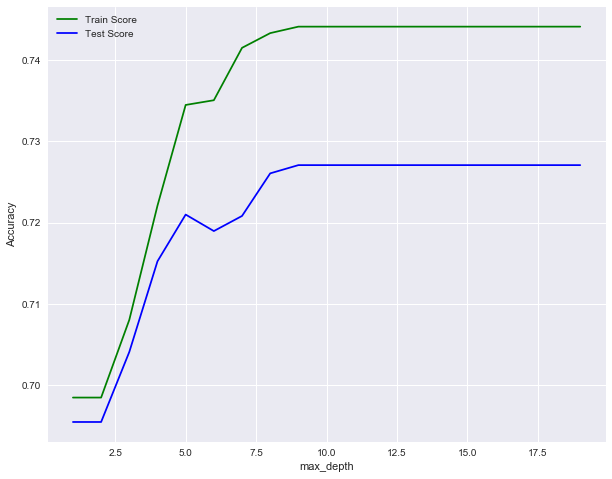

In [83]:
from sklearn.tree import DecisionTreeClassifier

sns.set(rc={'figure.figsize':(10,8)})

train_score_array = []
test_score_array = []

for n in range(1,20):
            dtree = DecisionTreeClassifier(criterion = 'gini', max_depth=n,min_samples_leaf=10,max_leaf_nodes=27)
            dtree.fit(xTrain,yTrain)
            train_score_array.append(dtree.score(xTrain,yTrain))
            test_score_array.append(dtree.score(xTest, yTest))

x_axis = range(1,20)
plt.plot(x_axis, train_score_array, label = 'Train Score', c = 'g')
plt.plot(x_axis, test_score_array, label = 'Test Score', c='b')
plt.xlabel('max_depth')
plt.ylabel('Accuracy')
plt.legend()

#### Learning Curve with respect to Max Leaf Nodes

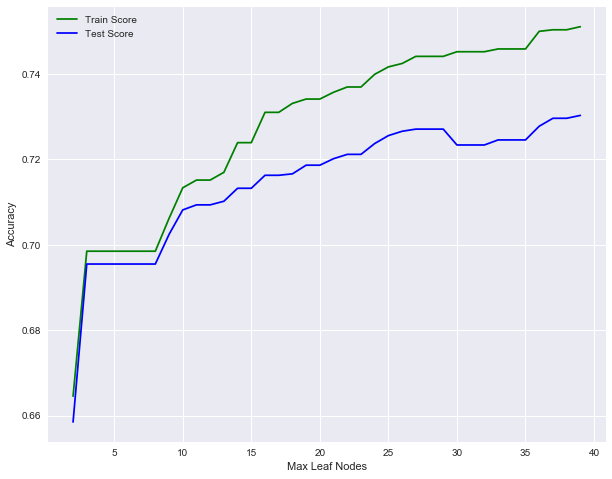

In [84]:
from sklearn.tree import DecisionTreeClassifier

sns.set(rc={'figure.figsize':(10,8)})

train_score_array = []
test_score_array = []

for n in range(2,40):
            dtree = DecisionTreeClassifier(criterion = 'gini', max_depth=9,min_samples_leaf=10,max_leaf_nodes=n)
            dtree.fit(xTrain,yTrain)
            train_score_array.append(dtree.score(xTrain,yTrain))
            test_score_array.append(dtree.score(xTest, yTest))

x_axis = range(2,40)
plt.plot(x_axis, train_score_array, label = 'Train Score', c = 'g')
plt.plot(x_axis, test_score_array, label = 'Test Score', c='b')
plt.xlabel('Max Leaf Nodes')
plt.ylabel('Accuracy')
plt.legend()

#### Learning Curve with respect to Min Samples Leaf

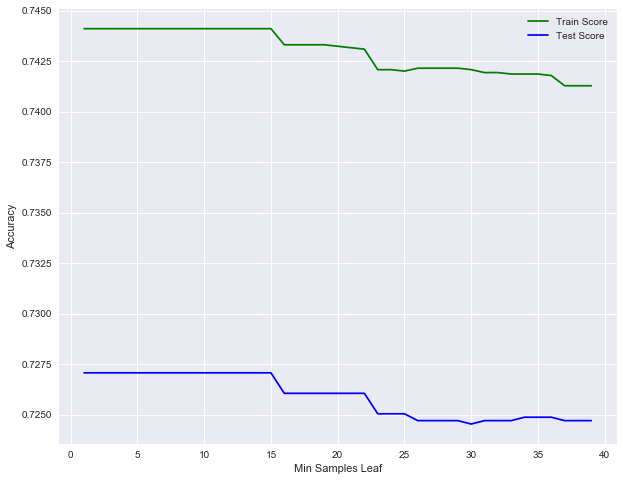

In [85]:
from sklearn.tree import DecisionTreeClassifier

sns.set(rc={'figure.figsize':(10,8)})

train_score_array = []
test_score_array = []

for n in range(1,40):
            dtree = DecisionTreeClassifier(criterion = 'gini', max_depth=9,min_samples_leaf=n,max_leaf_nodes=27)
            dtree.fit(xTrain,yTrain)
            train_score_array.append(dtree.score(xTrain,yTrain))
            test_score_array.append(dtree.score(xTest, yTest))

x_axis = range(1,40)
plt.plot(x_axis, train_score_array, label = 'Train Score', c = 'g')
plt.plot(x_axis, test_score_array, label = 'Test Score', c='b')
plt.xlabel('Min Samples Leaf')
plt.ylabel('Accuracy')
plt.legend()

### (b) For Cross_Validation Split

### Full Length Tree

In [113]:
from sklearn.tree import DecisionTreeClassifier

dtree_cv=DecisionTreeClassifier(criterion='gini')

dtree_cv.fit(xTrain_cv,yTrain_cv)
y_pred_cv=dtree_cv.predict(xTest_cv)

print('Train score: {:.4f} %'.format(dtree_cv.score(xTrain_cv,yTrain_cv)*100))
print('Test score: {:.4f} %'.format(dtree_cv.score(xTest_cv, yTest_cv)*100))

Train score: 100.0000 %
Test score: 62.8991 %


### Experimentation with Pruning

Pruning to Avoid Overfitting

Pruning helps us to avoid overfitting

Generally it is preferred to have a simple model, it avoids overfitting issue
Any additional split that does not add significant value is not worth while.
We can avoid overfitting by changing the parameters like

#### max_leaf_nodes
#### min_samples_leaf
#### max_depth

### Pruning Parameters
#### max_leaf_nodes: Reduce the number of leaf nodes
#### min_samples_leaf: Restrict the size of sample leaf
#### Minimum sample size in terminal nodes can be fixed to 30, 100, 300 or 5% of total max_depth

Reduce the depth of the tree to build a generalized tree
Set the depth of the tree to 3, 5, 10 depending after verification on test data

In [67]:
from sklearn.tree import DecisionTreeClassifier
best_score=0

for n in range(1,20):
    for m in [10,15,20,25,30,35,40,50]:
        for l in range(2,30):
            dtree_cv = DecisionTreeClassifier(criterion = 'gini', max_depth=n,max_leaf_nodes=l,min_samples_leaf=m)
            dtree_cv.fit(xTrain_cv,yTrain_cv)
            score=dtree_cv.score(xTest_cv,yTest_cv)
            if(score>best_score):
                best_score=score
                best_parameters={'max_depth':n,'min_samples_leaf':m,'max_leaf_nodes':l}

print(best_parameters)

{'max_depth': 5, 'min_samples_leaf': 10, 'max_leaf_nodes': 28}


In [20]:
dtree_cv=DecisionTreeClassifier(max_depth=5,criterion='gini',min_samples_leaf=10,max_leaf_nodes=28)

dtree_cv.fit(xTrain_cv,yTrain_cv)
y_pred_cv=dtree_cv.predict(xTest_cv)

print('Train score: {:.4f} %'.format(dtree_cv.score(xTrain_cv,yTrain_cv)*100))
print('Test score: {:.4f} %'.format(dtree_cv.score(xTest_cv, yTest_cv)*100))

print('Classification Report:')
print(classification_report(yTest_cv,y_pred_cv))
print('Confusion Matrix:')
print(confusion_matrix(yTest_cv,y_pred_cv))

Train score: 73.9331 %
Test score: 73.7962 %
Classification Report:
             precision    recall  f1-score   support

          0       0.54      0.13      0.21       527
          1       0.75      0.96      0.84      1446

avg / total       0.69      0.74      0.67      1973

Confusion Matrix:
[[  67  460]
 [  57 1389]]


In [77]:
from pprint import pprint
pprint(dtree_cv.get_params())

{'class_weight': None,
 'criterion': 'gini',
 'max_depth': 5,
 'max_features': None,
 'max_leaf_nodes': 28,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 10,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': False,
 'random_state': None,
 'splitter': 'best'}


#### Learning Curve with respect to Max depth

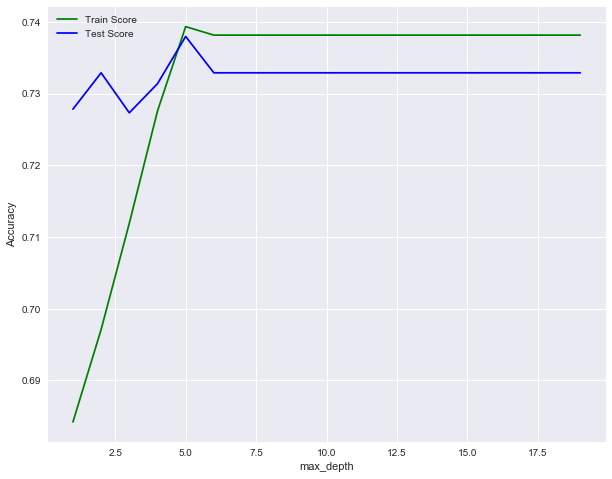

In [69]:
from sklearn.tree import DecisionTreeClassifier

sns.set(rc={'figure.figsize':(10,8)})

train_score_array = []
test_score_array = []

for n in range(1,20):
            dtree_cv = DecisionTreeClassifier(criterion = 'gini', max_depth=n,min_samples_leaf=10,max_leaf_nodes=28)
            dtree_cv.fit(xTrain_cv,yTrain_cv)
            train_score_array.append(dtree_cv.score(xTrain_cv,yTrain_cv))
            test_score_array.append(dtree_cv.score(xTest_cv, yTest_cv))

x_axis = range(1,20)
plt.plot(x_axis, train_score_array, label = 'Train Score', c = 'g')
plt.plot(x_axis, test_score_array, label = 'Test Score', c='b')
plt.xlabel('max_depth')
plt.ylabel('Accuracy')
plt.legend()

#### Learning Curve with respect to Max Leaf Nodes

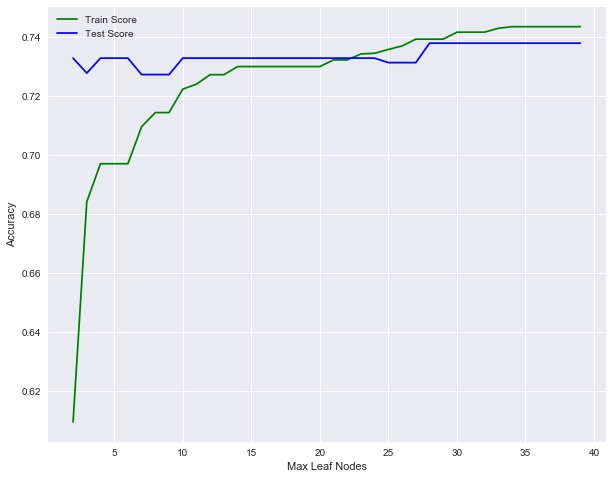

In [73]:
from sklearn.tree import DecisionTreeClassifier

sns.set(rc={'figure.figsize':(10,8)})

train_score_array = []
test_score_array = []

for n in range(2,40):
            dtree_cv = DecisionTreeClassifier(criterion = 'gini', max_depth=5,min_samples_leaf=10,max_leaf_nodes=n)
            dtree_cv.fit(xTrain_cv,yTrain_cv)
            train_score_array.append(dtree_cv.score(xTrain_cv,yTrain_cv))
            test_score_array.append(dtree_cv.score(xTest_cv, yTest_cv))

x_axis = range(2,40)
plt.plot(x_axis, train_score_array, label = 'Train Score', c = 'g')
plt.plot(x_axis, test_score_array, label = 'Test Score', c='b')
plt.xlabel('Max Leaf Nodes')
plt.ylabel('Accuracy')
plt.legend()

#### Learning Curve with respect to Min Samples Leaf

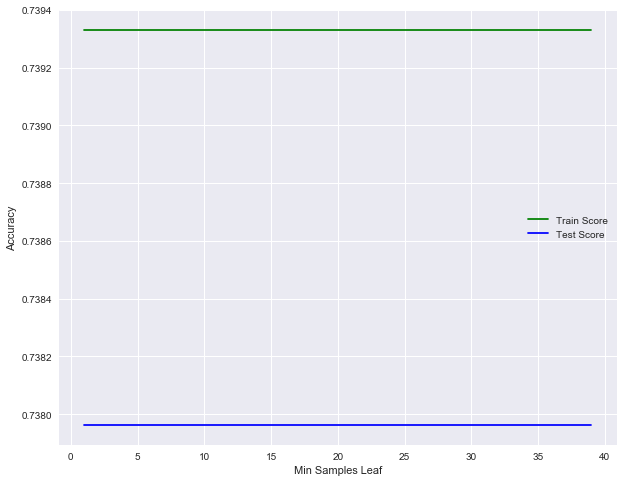

In [74]:
from sklearn.tree import DecisionTreeClassifier

sns.set(rc={'figure.figsize':(10,8)})

train_score_array = []
test_score_array = []

for n in range(1,40):
            dtree_cv = DecisionTreeClassifier(criterion = 'gini', max_depth=5,min_samples_leaf=n,max_leaf_nodes=28)
            dtree_cv.fit(xTrain_cv,yTrain_cv)
            train_score_array.append(dtree_cv.score(xTrain_cv,yTrain_cv))
            test_score_array.append(dtree_cv.score(xTest_cv, yTest_cv))

x_axis = range(1,40)
plt.plot(x_axis, train_score_array, label = 'Train Score', c = 'g')
plt.plot(x_axis, test_score_array, label = 'Test Score', c='b')
plt.xlabel('Min Samples Leaf')
plt.ylabel('Accuracy')
plt.legend()

## [3] Boosting

### (a) For Train-Test-Split-

In [86]:
from xgboost import XGBClassifier
xgb = XGBClassifier()

xgb.fit(xTrain,yTrain)
y_pred=xgb.predict(xTest)

print('Train score: {:.4f} %'.format(xgb.score(xTrain,yTrain)*100))
print('Test score: {:.4f} %'.format(xgb.score(xTest, yTest)*100))

Train score: 75.6841 %
Test score: 74.0584 %


In [87]:
pprint(xgb.get_params())

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 3,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 100,
 'n_jobs': 1,
 'nthread': None,
 'objective': 'binary:logistic',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': None,
 'silent': True,
 'subsample': 1}


### Experimentation with Pruning for XGBoost:

In [89]:
best_score=0

for n in [0.001,0.01,0.1,1,10,100]:
    for m in [50,100,150,200]:
        for l in range(1,10):
            xgb = XGBClassifier(learning_rate=n,n_estimators=m,max_depth=l)
            xgb.fit(xTrain,yTrain)
            score=xgb.score(xTest, yTest)
            if(score>best_score):
                best_score=score
                best_parameters = {'learning_rate': n,'n_estimators':m,'max_depth':l}

print(best_parameters)

{'learning_rate': 0.1, 'n_estimators': 200, 'max_depth': 8}


In [90]:
xgb=XGBClassifier(max_depth=8,n_estimators=200,learning_rate=0.1)

xgb.fit(xTrain,yTrain)
y_pred=xgb.predict(xTest)

print('Train score: {:.4f} %'.format(xgb.score(xTrain,yTrain)*100))
print('Test score: {:.4f} %'.format(xgb.score(xTest, yTest)*100))

print('Classification Report:')
print(classification_report(yTest,y_pred))
print('Confusion Matrix:')
print(confusion_matrix(yTest,y_pred))

Train score: 94.9544 %
Test score: 81.7429 %
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.74      0.75      2192
           1       0.85      0.87      0.86      3729

   micro avg       0.82      0.82      0.82      5921
   macro avg       0.81      0.80      0.80      5921
weighted avg       0.82      0.82      0.82      5921

Confusion Matrix:
[[1613  579]
 [ 502 3227]]


In [91]:
from pprint import pprint
pprint(xgb.get_params())

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 8,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 200,
 'n_jobs': 1,
 'nthread': None,
 'objective': 'binary:logistic',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': None,
 'silent': True,
 'subsample': 1}


#### Learning curve with respect to learning rate

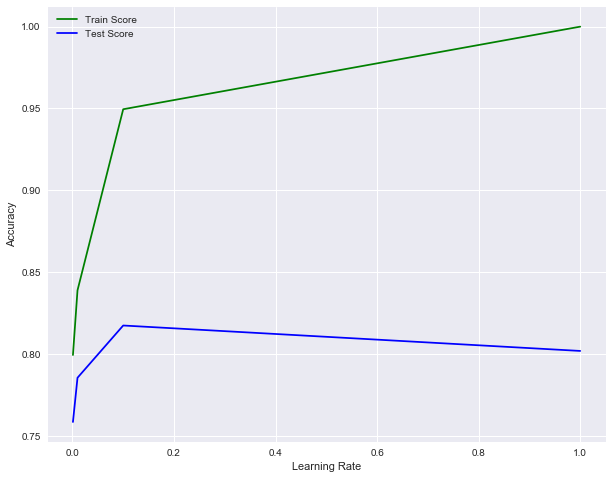

In [94]:
sns.set(rc={'figure.figsize':(10,8)})

train_score_array = []
test_score_array = []

for n in [0.001,0.01,0.1,1]:
            xgb = XGBClassifier( max_depth=8,learning_rate=n,n_estimators=200)
            xgb.fit(xTrain,yTrain)
            train_score_array.append(xgb.score(xTrain,yTrain))
            test_score_array.append(xgb.score(xTest, yTest))

x_axis = [0.001,0.01,0.1,1]
plt.plot(x_axis, train_score_array, label = 'Train Score', c = 'g')
plt.plot(x_axis, test_score_array, label = 'Test Score', c='b')
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')
plt.legend()

#### Learning Curve with respect to max_depth

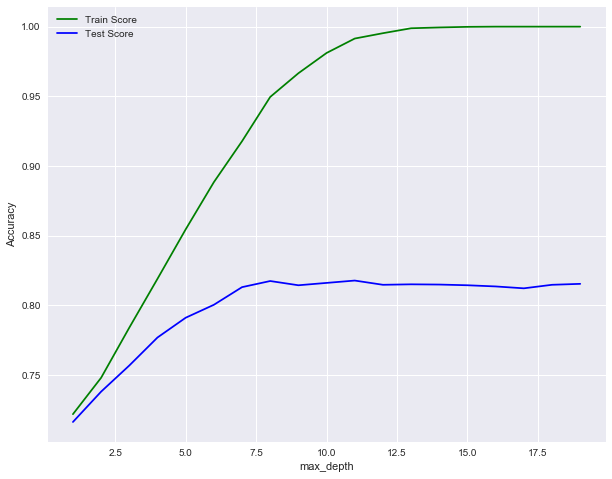

In [96]:
sns.set(rc={'figure.figsize':(10,8)})

train_score_array = []
test_score_array = []

for n in range(1,20):
            xgb = XGBClassifier( max_depth=n,learning_rate=0.1,n_estimators=200)
            xgb.fit(xTrain,yTrain)
            train_score_array.append(xgb.score(xTrain,yTrain))
            test_score_array.append(xgb.score(xTest, yTest))

x_axis = range(1,20)
plt.plot(x_axis, train_score_array, label = 'Train Score', c = 'g')
plt.plot(x_axis, test_score_array, label = 'Test Score', c='b')
plt.xlabel('max_depth')
plt.ylabel('Accuracy')
plt.legend()

#### Learning Curve with respect to n-estimators

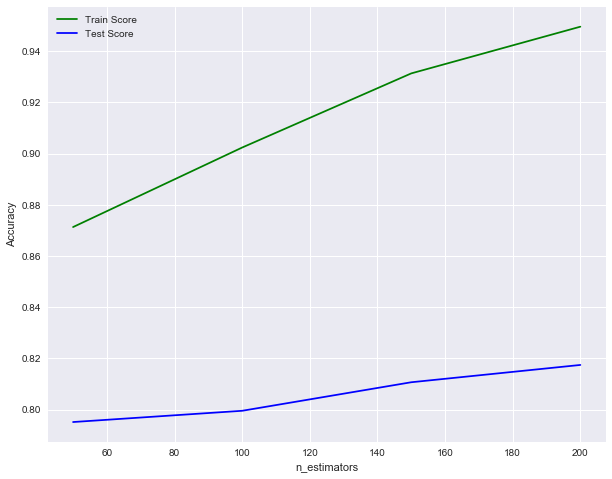

In [98]:
sns.set(rc={'figure.figsize':(10,8)})

train_score_array = []
test_score_array = []

for n in [50,100,150,200]:
            xgb = XGBClassifier( max_depth=8,learning_rate=0.1,n_estimators=n)
            xgb.fit(xTrain,yTrain)
            train_score_array.append(xgb.score(xTrain,yTrain))
            test_score_array.append(xgb.score(xTest, yTest))

x_axis = [50,100,150,200]
plt.plot(x_axis, train_score_array, label = 'Train Score', c = 'g')
plt.plot(x_axis, test_score_array, label = 'Test Score', c='b')
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')
plt.legend()

### (b) For Cross-Validation-

In [101]:
from xgboost import XGBClassifier
xgb_cv = XGBClassifier()

xgb_cv.fit(xTrain_cv,yTrain_cv)
y_pred_cv=xgb_cv.predict(xTest_cv)

print('Train score: {:.4f} %'.format(xgb_cv.score(xTrain_cv,yTrain_cv)*100))
print('Test score: {:.4f} %'.format(xgb_cv.score(xTest_cv, yTest_cv)*100))

Train score: 75.4926 %
Test score: 73.6949 %


In [102]:
pprint(xgb_cv.get_params())

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 3,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 100,
 'n_jobs': 1,
 'nthread': None,
 'objective': 'binary:logistic',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': None,
 'silent': True,
 'subsample': 1}


### Experimentation with Pruning for XGBoost:

In [103]:
best_score=0

for n in [0.001,0.01,0.1,1,10,100]:
    for m in [50,100,150,200]:
        for l in range(1,10):
            xgb_cv = XGBClassifier(learning_rate=n,n_estimators=m,max_depth=l)
            xgb_cv.fit(xTrain_cv,yTrain_cv)
            score=xgb_cv.score(xTest_cv, yTest_cv)
            if(score>best_score):
                best_score=score
                best_parameters = {'learning_rate': n,'n_estimators':m,'max_depth':l}

print(best_parameters)

{'learning_rate': 1, 'n_estimators': 50, 'max_depth': 3}


In [105]:
xgb_cv=XGBClassifier(max_depth=3,n_estimators=50,learning_rate=1)

xgb_cv.fit(xTrain_cv,yTrain_cv)
y_pred_cv=xgb_cv.predict(xTest_cv)

print('Train score: {:.4f} %'.format(xgb_cv.score(xTrain_cv,yTrain_cv)*100))
print('Test score: {:.4f} %'.format(xgb_cv.score(xTest_cv, yTest_cv)*100))

print('Classification Report:')
print(classification_report(yTest_cv,y_pred_cv))
print('Confusion Matrix:')
print(confusion_matrix(yTest_cv,y_pred_cv))

Train score: 81.9784 %
Test score: 75.1647 %
Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.24      0.34       527
           1       0.77      0.94      0.85      1446

   micro avg       0.75      0.75      0.75      1973
   macro avg       0.68      0.59      0.60      1973
weighted avg       0.72      0.75      0.71      1973

Confusion Matrix:
[[ 129  398]
 [  92 1354]]


In [106]:
from pprint import pprint
pprint(xgb_cv.get_params())

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'learning_rate': 1,
 'max_delta_step': 0,
 'max_depth': 3,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 50,
 'n_jobs': 1,
 'nthread': None,
 'objective': 'binary:logistic',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': None,
 'silent': True,
 'subsample': 1}


#### Learning curve with respect to learning rate

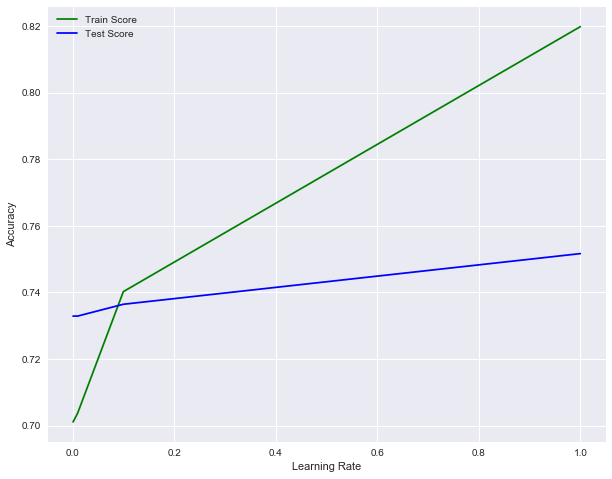

In [107]:
sns.set(rc={'figure.figsize':(10,8)})

train_score_array = []
test_score_array = []

for n in [0.001,0.01,0.1,1]:
            xgb_cv = XGBClassifier( max_depth=3,learning_rate=n,n_estimators=50)
            xgb_cv.fit(xTrain_cv,yTrain_cv)
            train_score_array.append(xgb_cv.score(xTrain_cv,yTrain_cv))
            test_score_array.append(xgb_cv.score(xTest_cv, yTest_cv))

x_axis = [0.001,0.01,0.1,1]
plt.plot(x_axis, train_score_array, label = 'Train Score', c = 'g')
plt.plot(x_axis, test_score_array, label = 'Test Score', c='b')
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')
plt.legend()

#### Learning Curve with respect to max_depth

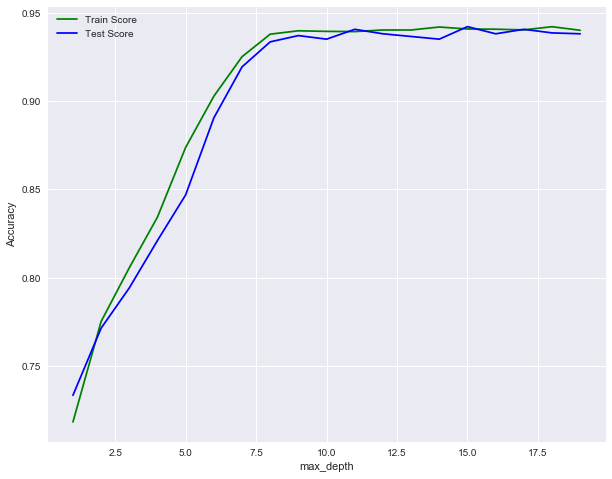

In [108]:
sns.set(rc={'figure.figsize':(10,8)})

train_score_array = []
test_score_array = []

for n in range(1,20):
            xgb_cv = XGBClassifier( max_depth=n,learning_rate=1,n_estimators=50)
            xgb_cv.fit(xTrain,yTrain)
            train_score_array.append(xgb_cv.score(xTrain_cv,yTrain_cv))
            test_score_array.append(xgb_cv.score(xTest_cv, yTest_cv))

x_axis = range(1,20)
plt.plot(x_axis, train_score_array, label = 'Train Score', c = 'g')
plt.plot(x_axis, test_score_array, label = 'Test Score', c='b')
plt.xlabel('max_depth')
plt.ylabel('Accuracy')
plt.legend()

#### Learning Curve with respect to n-estimators

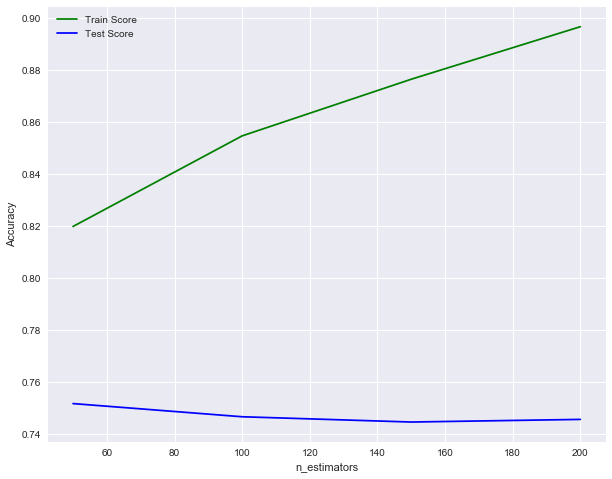

In [112]:
sns.set(rc={'figure.figsize':(10,8)})

train_score_array = []
test_score_array = []

for n in [50,100,150,200]:
            xgb_cv = XGBClassifier( max_depth=3,learning_rate=1,n_estimators=n)
            xgb_cv.fit(xTrain_cv,yTrain_cv)
            train_score_array.append(xgb_cv.score(xTrain_cv,yTrain_cv))
            test_score_array.append(xgb_cv.score(xTest_cv, yTest_cv))

x_axis = [50,100,150,200]
plt.plot(x_axis, train_score_array, label = 'Train Score', c = 'g')
plt.plot(x_axis, test_score_array, label = 'Test Score', c='b')
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')
plt.legend()